# **Customer Churn Prediction Using Machine Learning**

**Goal:** Predict customer churn using supervised machine learning and translate model outputs into business actions.

**Dataset:** Telco Customer Churn (Kaggle)

**Best Model:** Gradient Boosting Classifier

**Key focus:** Model comparison, threshold tuning, and interpretability for decision support.


## Project Overview

This project builds a machine learning model to predict whether a customer will churn. Churn prediction helps businesses identify customers who are likely to leave and take proactive retention actions. The workflow covers the full supervised learning pipeline:

* Data loading and quality checks
* Preprocessing (imputation, encoding, scaling)
* Model training and comparison
* Evaluation using ROC-AUC, confusion matrix, and class metrics
* Business-focused threshold tuning to increase churn recall
* Feature importance to explain the main churn drivers
* Recommendations based on model insights


## Introduction

Customer churn is a critical business problem because retaining customers is usually cheaper than acquiring new ones. A churn model supports retention strategies by ranking customers by risk and helping teams target interventions effectively.

In this project, the main objective is to build a reliable churn classifier and evaluate it using metrics that are meaningful for churn use cases. Accuracy alone is not sufficient because churn data is often imbalanced. Instead, we focus on:

* **ROC-AUC** for discrimination quality
* **Recall (Churn)** to reduce missed churners
* Threshold tuning to match retention objectives


In [26]:
# Setup: Imports and Settings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

RANDOM_STATE = 42

## Load Dataset

We use the Telco Customer Churn dataset, which includes customer demographics, subscription/services, contract information, and billing details. The target label is **Churn** (Yes/No).

**Input file path**
https://drive.google.com/file/d/12tEHXiGJ_1nyhdtd5ApuMTa6L10gyBPv/view?usp=sharing


In [28]:
# Load Data

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())



Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Quality Checks

Here I'll inspect:

* Data types and basic structure
* Missing values
* Class balance (churn distribution)

This helps identify preprocessing needs and sets expectations for evaluation metrics.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


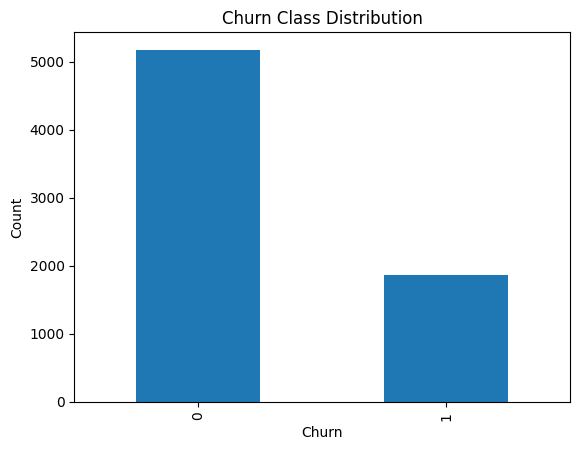

In [27]:
print(df.info())
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False).head(15))

# Target distribution
ax = df["Churn"].value_counts().plot(kind="bar")
ax.set_title("Churn Class Distribution")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
plt.show()

## Data Cleaning

Here, I have found some common issues in this dataset:

* `TotalCharges` may be stored as text due to blank entries
* `customerID` is an identifier and not useful for prediction
* Target label is converted into binary format (Yes = 1, No = 0)


In [29]:
# Convert TotalCharges to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop ID column if present
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Convert target to 0/1
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

## Train/Test Split

Now, I'll split the dataset into training and testing subsets using stratification so that the churn proportion remains consistent in both sets. This improves evaluation reliability.


In [30]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (5634, 19) Test size: (1409, 19)


## Preprocessing Pipeline

I use a robust preprocessing pipeline to find:

* Numeric features: imputation + scaling
* Categorical features: imputation + one-hot encoding

Using `ColumnTransformer` and `Pipeline` ensures the full workflow is reproducible and prevents data leakage.


In [32]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# Helper Functions

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return auc


def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0, 1], ["No", "Yes"])
    plt.yticks([0, 1], ["No", "Yes"])

    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()


def evaluate_model(name, model_pipeline):
    model_pipeline.fit(X_train, y_train)

    # Probabilities for ROC-AUC and threshold tuning
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred = model_pipeline.predict(X_test)

    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== {name} =====")
    print(f"ROC-AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

    plot_confusion(y_test, y_pred, title=f"{name} - Confusion Matrix")
    plot_roc_curve(y_test, y_prob, title=f"{name} - ROC Curve")

    return {
        "model": name,
        "roc_auc": auc,
        "pipeline": model_pipeline,
        "y_prob": y_prob
    }

## Model Training and Comparison

In this project, I will train and evaluate three models:

1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting

I will compare them using ROC-AUC and class-level metrics.



===== Logistic Regression =====
ROC-AUC: 0.841
              precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1035
       Churn       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



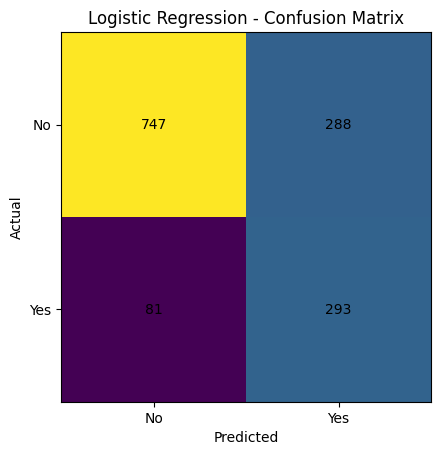

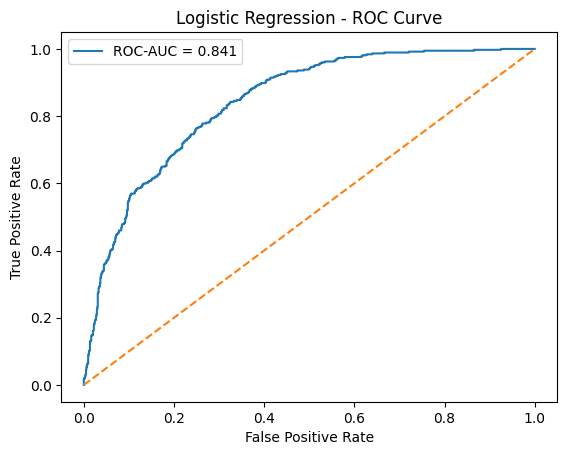

In [31]:
# Logistic Regression

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

res_lr = evaluate_model("Logistic Regression", log_reg)





===== Random Forest =====
ROC-AUC: 0.822
              precision    recall  f1-score   support

    No Churn       0.82      0.90      0.86      1035
       Churn       0.62      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



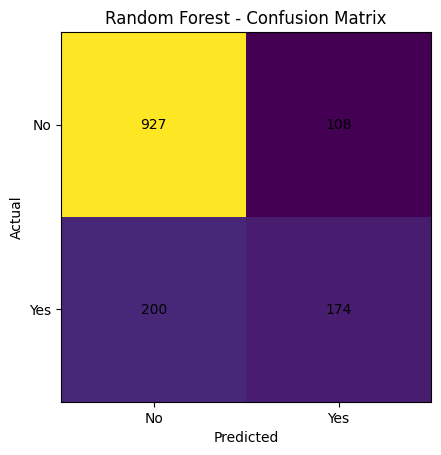

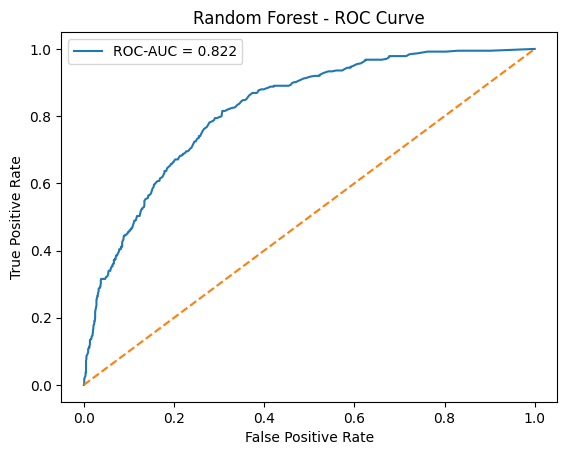

In [33]:
# Random Forest

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])

res_rf = evaluate_model("Random Forest", rf)


===== Gradient Boosting =====
ROC-AUC: 0.843
              precision    recall  f1-score   support

    No Churn       0.84      0.91      0.87      1035
       Churn       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



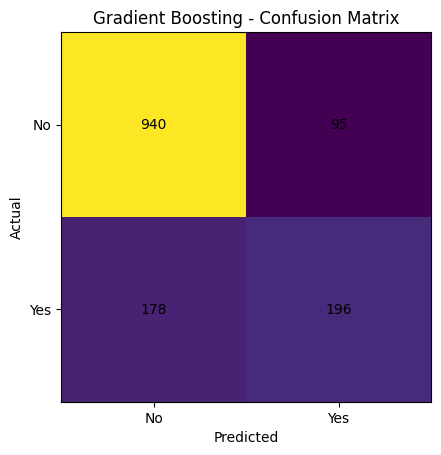

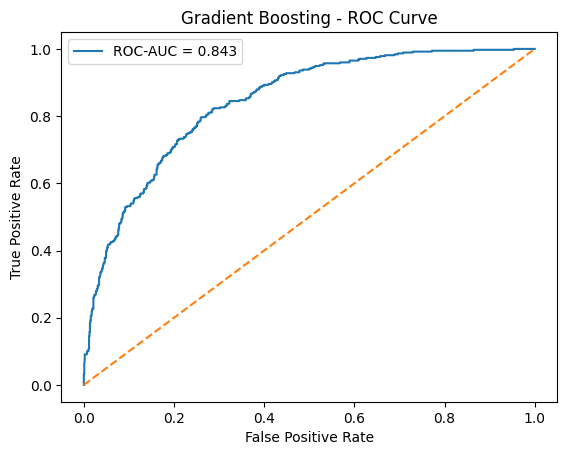

In [34]:
# Gradient Boosting

gb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

res_gb = evaluate_model("Gradient Boosting", gb)

In [16]:
# Model Comparison Table

results = pd.DataFrame([
    {"Model": res_lr["model"], "ROC-AUC": res_lr["roc_auc"]},
    {"Model": res_rf["model"], "ROC-AUC": res_rf["roc_auc"]},
    {"Model": res_gb["model"], "ROC-AUC": res_gb["roc_auc"]},
]).sort_values("ROC-AUC", ascending=False)

display(results)

,Model,ROC-AUC
2,Gradient Boosting,0.843362
0,Logistic Regression,0.841298
1,Random Forest,0.821673


## Threshold Tuning

Default thresholds may miss churners. In retention use cases, missing churners can be costly, so I tune the decision threshold to increase **churn recall**.

I will select a threshold that targets recall around 0.75, accepting a trade-off in precision.


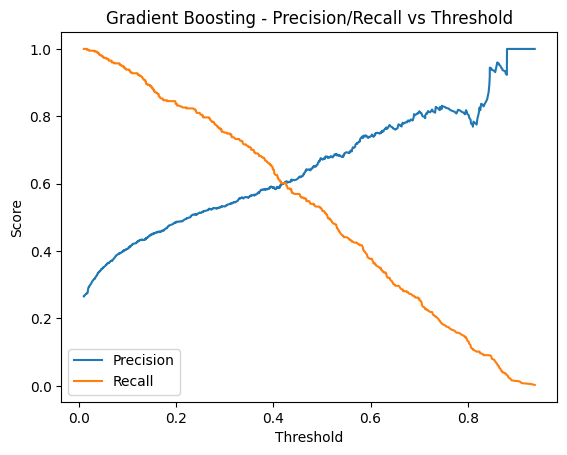

In [36]:
# Choose the best model by ROC-AUC
best = max([res_lr, res_rf, res_gb], key=lambda x: x["roc_auc"])
best_name = best["model"]
best_pipe = best["pipeline"]
y_prob = best["y_prob"]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.title(f"{best_name} - Precision/Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()



Chosen threshold: 0.297 for target recall ~ 0.75

Classification report with tuned threshold:
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.82      1035
       Churn       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



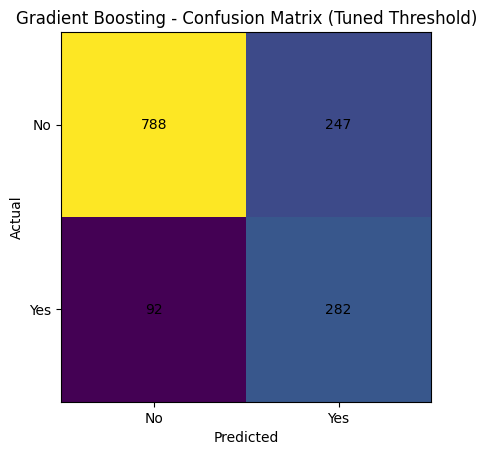

In [37]:
# Pick threshold to prioritize recall (catch churners)
target_recall = 0.75
idx = np.argmin(np.abs(recall - target_recall))
chosen_threshold = thresholds[max(idx - 1, 0)]
print("Chosen threshold:", round(float(chosen_threshold), 3), "for target recall ~", target_recall)

y_pred_thresh = (y_prob >= chosen_threshold).astype(int)
print("\nClassification report with tuned threshold:")
print(classification_report(y_test, y_pred_thresh, target_names=["No Churn", "Churn"]))
plot_confusion(y_test, y_pred_thresh, title=f"{best_name} - Confusion Matrix (Tuned Threshold)")

## Interpretability: Feature Importance

To make model results useful for decision-making, I extract feature importance and identify the strongest churn drivers. This helps translate model behavior into actionable business insights.


Top 10 Features Driving Churn Prediction:


,feature,importance
0,Contract_Month-to-month,0.379910
1,tenure,0.138682
2,InternetService_Fiber optic,0.086523
3,TotalCharges,0.085531
4,MonthlyCharges,0.082426
5,OnlineSecurity_No,0.068142
6,PaymentMethod_Electronic check,0.044214
7,TechSupport_No,0.037855
8,PaperlessBilling_Yes,0.011227
9,MultipleLines_No,0.010302


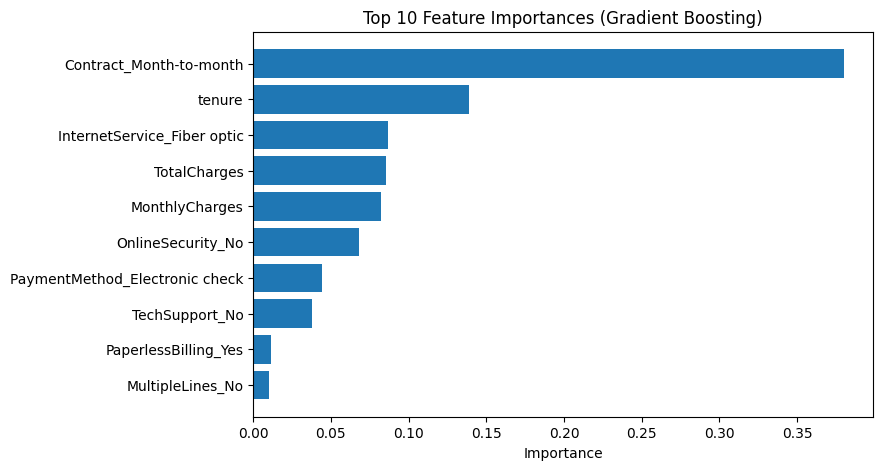

In [38]:
pre = best_pipe.named_steps["preprocess"]
model = best_pipe.named_steps["model"]

# Get feature names after preprocessing
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_

    fi = (
        pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    print("Top 10 Features Driving Churn Prediction:")
    display(fi.head(10))

    plt.figure(figsize=(8, 5))
    plt.barh(fi.head(10)["feature"][::-1], fi.head(10)["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Feature Importances ({best_name})")
    plt.show()

elif hasattr(model, "coef_"):
    coefs = model.coef_[0]

    coef_df = (
        pd.DataFrame({
            "feature": feature_names,
            "coefficient": coefs
        })
        .sort_values("coefficient", ascending=False)
        .reset_index(drop=True)
    )

    print("Top Features Increasing Churn Risk:")
    display(coef_df.head(10))

    print("Top Features Reducing Churn Risk:")
    display(coef_df.tail(10))


## Final Model Summary

**Best model:** Gradient Boosting Classifier

**ROC-AUC:** 0.843

**Threshold tuning:** Selected threshold 0.297 to target churn recall around 0.75

This approach prioritizes capturing churners (high recall) for retention interventions, accepting more false positives as a business trade-off.


## Key Insights

* **Month-to-month contracts** are the strongest churn driver, contributing the highest importance in the model.
* **Customer tenure** strongly influences churn; newer customers are at higher risk.
* **Fiber optic internet** customers show higher churn risk, likely linked to pricing expectations or service experience.
* **MonthlyCharges and TotalCharges** are major churn signals, suggesting price sensitivity.
* Missing **OnlineSecurity** and **TechSupport** is strongly associated with churn.
* **Electronic check** payment method is linked with higher churn behavior.


## Business Recommendations

* Focus retention efforts on customers with **month-to-month contracts**, especially those with short tenure.
* Provide incentives for customers to switch to longer-term contracts.
* Create targeted offers for customers with **high monthly charges**, such as bundled services or plan adjustments.
* Improve early onboarding and support for new customers to reduce short-tenure churn.
* Promote or bundle **online security** and **tech support** to reduce churn risk.
* Review churn patterns for customers using **electronic checks** and encourage lower-risk payment methods.
* Use churn probability scores with a tuned threshold (0.297) to trigger proactive outreach.


## Conclusion

This project built a complete churn prediction pipeline using proper preprocessing, model comparison, and business-aware evaluation. Gradient Boosting achieved the best overall ROC-AUC (0.843). Because churn use cases often prioritize catching churners, threshold tuning improved churn recall to approximately 0.75, making the model more useful for retention targeting.

The model highlights clear churn drivers including month-to-month contracts, short tenure, higher charges, lack of support services, and electronic check payment behavior. These insights can guide retention strategies and help businesses reduce churn through targeted interventions.
